### Preprocessing

---

From the authors of Homepage2Vec, we were given crowdsourced annotated data for roughly 800 homepages. Each homepage was labeled independently by three labelers. Our goal in this notebook to obtain a single label for each homepage. 

### Setup

---


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score

import os
import json

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
import bleach

import warnings

warnings.filterwarnings("ignore")

from ml_project_2_mlp import utils

In [3]:
sns.set_style("dark")
sns.set_palette("gist_stern")

### Load Data

---


In [4]:
load_path = os.path.join("..", "data", "crowdsourced", "labeled.csv")
labeled = pd.read_csv(load_path)

In [5]:
idx2cat = {
    "0": 'Arts', 
    "1": 'Business', 
    "2": 'Computers',
    "3": 'Games', 
    "4": 'Health',
    "5": 'Home', 
    "6": 'Kids_and_Teens', 
    "7": 'News', 
    "8": 'Recreation', 
    "9": 'Reference', 
    "10": 'Science', 
    "11": 'Shopping', 
    "12": 'Society', 
    "13": 'Sports'
}

cat2idx = {v : k for k, v in idx2cat.items()}

### Crowdsourced Data: Labeling Analysis

---


Let's start with some basic EDA:


In [6]:
print(f"Task title: {labeled['Title'][0]}")
print(f"Task description: {labeled['Description'][0]}")
print(f"Task reward: {labeled['Reward'][0]}")

Task title: Select all categories that are relevant for the website (English websites)
Task description: Given a screenshot, title, and description of a website, select all the relevant categories.
Task reward: $0.10


In [7]:
# Number of records per unique page
number_of_labels, count = np.unique(
    labeled["Input.uid"].value_counts(), return_counts=True
)
for numlabels, c in zip(number_of_labels, count):
    print(f"There are {c} websites each annotated by {numlabels} labelers")

# Show the unique responses for each question
answers = set()
for answer in labeled["Answer.taskAnswers"]:
    parsed_answer = json.loads(answer)
    answers.update([v for v in parsed_answer[0].values() if type(v) == str])
print(f"There are {len(answers)} unique responses: {answers}")

# Average number of labels per user
avg_user_labels = labeled["WorkerId"].value_counts().mean()
print(f"On average each labeler annotated {avg_user_labels} pages")

There are 840 websites each annotated by 3 labelers
There are 3 unique responses: {'UNSURE', 'NO', 'YES'}
On average each labeler annotated 60.0 pages


In [8]:
# Make sure that for all records, AssignmentStatus is Approved
assert (
    len(labeled["AssignmentStatus"].unique()) == 1
    and labeled["AssignmentStatus"].unique()[0] == "Approved"
), "AssignmentStatus is not Approved"
print("✅ All records have AssignmentStatus Approved")

# Confirm that all pages are assigned with at most 3 assignments
max_assignments, count = np.unique(labeled["MaxAssignments"], return_counts=True)
assert len(max_assignments) == 1 and max_assignments[0] == 3, "MaxAssignments is not 3"
print("✅ This checks with the max assignments allowed.")


# Get Double Check that the list in TaskAnswers is of length 1 always
answers = set()
total = 0
for answer in labeled["Answer.taskAnswers"]:
    parsed_answer = json.loads(answer)
    if len(parsed_answer) > 1:
        total += 1
if total > 0:
    print(f"❗️ There are {total} records with taskAnswers list length > 1")
else:
    print("✅ All records has taskAnswers list length = 1")

# Check missing values for Input.url, Input.screenshot, Input.title, Input.description, report in percentage
for col in ["Input.url", "Input.screenshot", "Input.title", "Input.description"]:
    miss_vals = labeled[col].isna().sum() / len(labeled) * 100
    if miss_vals > 0:
        print(f"❗️ {col} has {miss_vals:.2f}% missing values")

✅ All records have AssignmentStatus Approved
✅ This checks with the max assignments allowed.
✅ All records has taskAnswers list length = 1
❗️ Input.title has 2.86% missing values
❗️ Input.description has 46.19% missing values


Next, let's one hot encode the column `Answer.taskAnswers` based on the
dictionary that each row includes:


In [9]:
# Create a new column AnswersParsed
labeled["AnswersParsed"] = labeled["Answer.taskAnswers"].apply(
    lambda x: {
        k.split("-")[-1]: v for k, v in json.loads(x)[0].items() if type(v) == str
    }
)

# Obtain the selected Idx and corresponding categories
labeled["SelectedIdx"] = labeled["AnswersParsed"].apply(
    lambda x: [k for k, v in x.items() if v == "YES"]
)
labeled["SelectedCategories"] = labeled["SelectedIdx"].apply(
    lambda x: [idx2cat[idx] for idx in x]
)

# Now, let's one hot encode the selected categories
for cat in cat2idx:
    labeled[cat] = labeled["SelectedCategories"].apply(lambda x: 1 if cat in x else 0)

relevant_columns = ["Input.uid", "Input.url"] + list(cat2idx)
labeled = labeled[relevant_columns]
labeled.head()

,Input.uid,Input.url,Arts,Business,Computers,Games,Health,Home,Kids_and_Teens,News,Recreation,Reference,Science,Shopping,Society,Sports
0,1161124,www.pointlesssites.com,0,0,1,1,0,1,1,0,1,0,0,0,0,0
1,1161124,www.pointlesssites.com,0,0,0,1,0,1,1,0,1,0,0,0,1,0
2,1161124,www.pointlesssites.com,1,0,1,0,0,0,0,0,1,0,0,0,0,0
3,1081241,www.connecticutplastics.com,0,1,1,0,1,0,0,0,0,0,1,0,0,0
4,1081241,www.connecticutplastics.com,0,0,0,0,1,0,0,0,0,0,0,0,0,0


Now, for each website and category, we want to look at the aggreement accross
annotators.


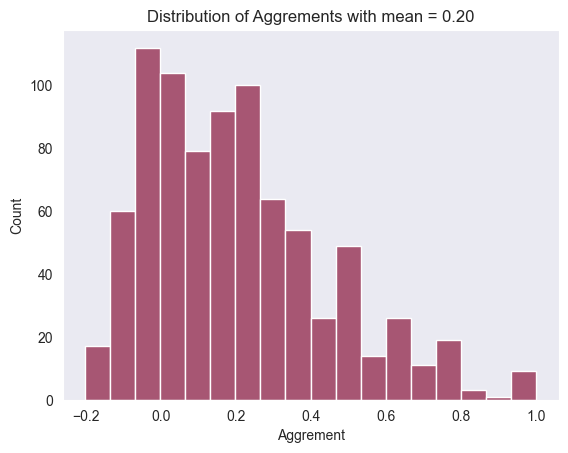

In [10]:
website_ids = labeled["Input.uid"].unique()
aggrements = []
for wid in website_ids:
    # Get all the annotations for this website
    annotations = labeled[labeled["Input.uid"] == wid].iloc[:, 2:].to_numpy()

    # Pair the annotations
    kappas = []
    for i in range(len(annotations)):
        for j in range(i + 1, len(annotations)):
            kappas.append(cohen_kappa_score(annotations[i], annotations[j]))

    # Take the average of all the kappas
    avg_kappa = np.mean(kappas)

    # If nan, then set to 0
    if np.isnan(avg_kappa):
        avg_kappa = 0

    # Save the average kappa for this website
    aggrements.append([wid, avg_kappa])

# Turn into pandas dataframe
aggrements = pd.DataFrame(aggrements, columns=["Input.uid", "Aggrement"])

# Plot the distribution of aggrements
sns.histplot(aggrements["Aggrement"])
plt.title(
    "Distribution of Aggrements with mean = {:.2f}".format(
        aggrements["Aggrement"].mean()
    )
);

Next, let's use different aggregation strategies to obtain final labels for each
webpage:


For threshold = 1, the mean number of categories per website is 7.66
For threshold = 2, the mean number of categories per website is 2.50
For threshold = 3, the mean number of categories per website is 0.54


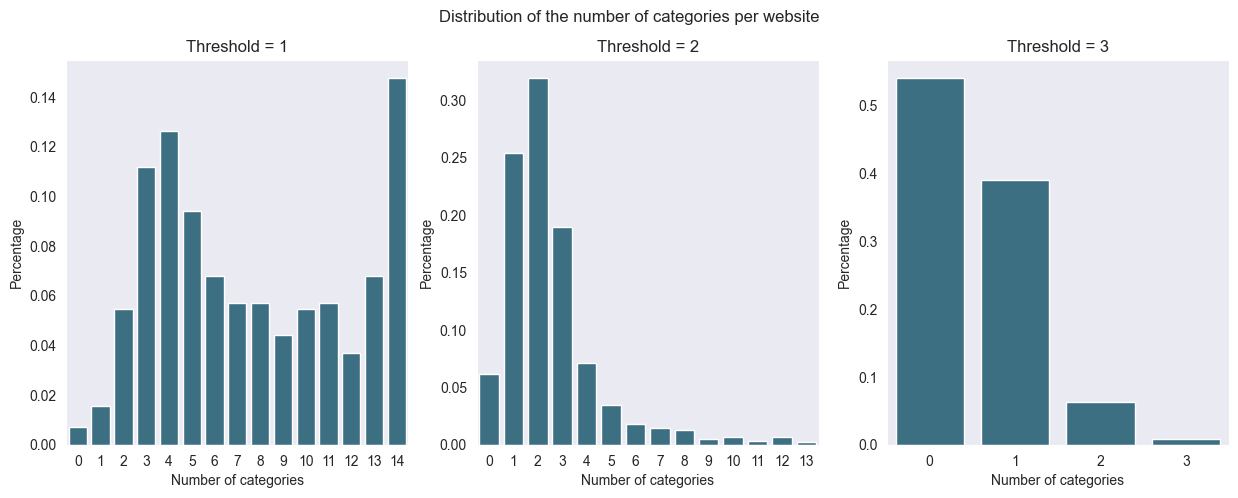

In [11]:
# Compute for each website the number of times the website was assigned given label
page_labc = labeled.groupby("Input.uid").sum()

# For each website, decided whether it belongs to the category or not based on the threshold = min. number of annotations
thresholds = [1, 2, 3]
thresholded = []
for t in thresholds:
    thresholded.append((page_labc.iloc[:, 1:] >= t).astype(int))

# Show the distribution of the number of categories per website
numlab_dist = [thresholded[t - 1].sum(axis=1) for t in thresholds]
print(
    f"For threshold = 1, the mean number of categories per website is {numlab_dist[0].mean():.2f}"
)
print(
    f"For threshold = 2, the mean number of categories per website is {numlab_dist[1].mean():.2f}"
)
print(
    f"For threshold = 3, the mean number of categories per website is {numlab_dist[2].mean():.2f}"
)

# Print the distribution of the number of categories per website
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    sns.barplot(
        x=numlab_dist[i].value_counts().index,
        y=numlab_dist[i].value_counts().values / numlab_dist[i].shape[0],
        ax=ax,
        color="#31748f",
    )

# Add the labels
axs[0].set_title("Threshold = 1")
axs[1].set_title("Threshold = 2")
axs[2].set_title("Threshold = 3")

for ax in axs:
    ax.set_xlabel("Number of categories")
    ax.set_ylabel("Percentage")

# Add title
fig.suptitle("Distribution of the number of categories per website");

Given these results, having all three annotators agree on a label results in a very low number of labels per website. On the opposite site, having at least one annotator agree on a label results in a very high number of labels per website. Therefore, we will the at least 2 annotators agree on a label strategy which is likely the best trade-off between the two extremes. Let's save the labels and websites obtained via this strategy to the corresponding folders:

In [12]:
wid_url = labeled[["Input.uid", "Input.url"]].drop_duplicates().rename({"Input.uid": "wid", "Input.url": "url"}, inplace=False, axis=1)

save_dir = os.path.join("..", "data", "raw")
save_path = os.path.join(save_dir, "original.csv")
os.makedirs(save_dir, exist_ok=True)

wid_url.to_csv(save_path, index=False)
wid_url.head()

,wid,url
0,1161124,www.pointlesssites.com
3,1081241,www.connecticutplastics.com
6,1162420,99percentinvisible.org
9,1146040,www.medicaid.gov
12,1117243,www.graalonline.com


In [13]:
t2 = thresholded[1].reset_index().rename({"Input.uid": "wid"}, inplace=False, axis=1)
wid2labels = dict()
for _, row in t2.iterrows():
    wid2labels[str(row["wid"])] = {"labels": row.iloc[1:].to_list()}

save_dir = os.path.join("../data/labels/human")
save_path = os.path.join(save_dir, "original.json")
os.makedirs(save_dir, exist_ok=True)

with open(save_path, "w") as f:
    json.dump(wid2labels, f)

keys = list(wid2labels.keys())
for k in keys[:5]:
    print(k, wid2labels[k])

125542 {'labels': [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]}
246754 {'labels': [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]}
290883 {'labels': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
312868 {'labels': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
382929 {'labels': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


---